In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_data
import preprocessing
import feature_extraction
import dimension_reduction
import classification
import matplotlib 
import os

test_size = 0.2
random_state = 104

[nltk_data] Downloading package wordnet to /home/makus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/makus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
os.chdir('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/bachelor-thesis/img/')

# load data

In [3]:
enron = import_data.create_df_enron('/home/makus/Documents/Semester_7_WIN2022/Bachelorarbeit/ba_code/datasets/enron/')
enron

,text,label
index,,
0,"Subject: hpl nom for february 9 , 2001\n( see ...",0
1,Subject: enron scheduled volumes - - - may 6 t...,0
2,"Subject: chevron phillips chemical co . , lp (...",0
3,Subject: same day change - hpl nom for novembe...,0
4,Subject: calpine daily gas nomination\n>\n>\nj...,0
...,...,...
33711,Subject: will cut the years 3 . 46 % ( 8 )\nh ...,1
33712,Subject: top stock to consider right now ?\ndy...,1
33713,Subject: congratulations ! ! !\nthe lottery de...,1


# feature extraction + dimension reduction

In [4]:
y = np.array(enron['label'],dtype=int)
mails = enron['text']

tfidf_mails = feature_extraction.tfidf_vectorize(mails)
sparse_mails = dimension_reduction.sparse_random_projection(tfidf_mails)
ipca_mails = dimension_reduction.ipca(sparse_mails, 100)
X = ipca_mails
del mails, tfidf_mails, sparse_mails, ipca_mails, enron

X.shape

It took 7.284430094994605 second(s) to finish TF-IDF feature extraction.
It took 13.97023425399675 second(s) to finish dimension reduction with Sparse Random Projection.
It took 231.52515999499883 second(s) to finish dimension reduction with IPCA.


(33716, 100)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


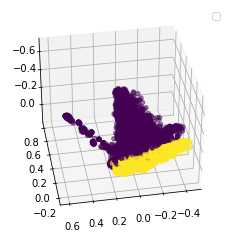

In [35]:
xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
colors = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=colors, alpha = 0.5)
ax.view_init(-145,100)
plt.savefig('enron_graph.pdf')
plt.show()

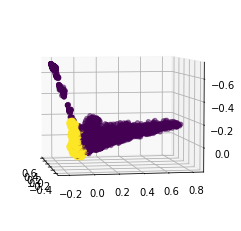

In [40]:
xs = X[:,0]
ys = X[:,1]
zs = X[:,2]
colors = y

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs, ys, zs, c=colors, alpha = 0.5)
ax.view_init(-175,10)
plt.savefig('enron_graph_two.pdf')
plt.show()

# Reference SVM classification

In [6]:
reference_report, X_test, y_test, y_pred = classification.svm(X,y,test_size, random_state)

reference_report

SVM model fitted in 48.92246241400426 second(s)
SVM predicted the testset in 6.618261836003512 second(s)


,0,1,accuracy,macro avg,weighted avg
precision,0.992157,0.936754,0.961892,0.964455,0.963609
recall,0.928724,0.993094,0.961892,0.960909,0.961892
f1-score,0.959393,0.964101,0.961892,0.961747,0.961819
support,3269.000000,3475.000000,0.961892,6744.000000,6744.000000


this is our reference svm for the comparison

Got 257 classificaton mistakes


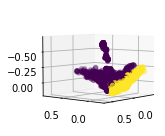

In [7]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

# K-Means + Elbow plot

Now we create our elbow graph. A cluster count above 25 has not much sense

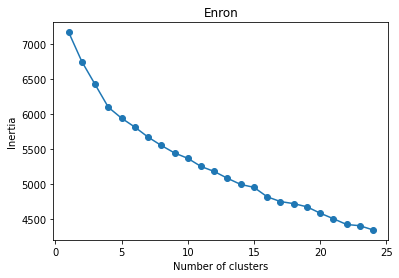

In [8]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X,max_cluster)

plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Enron')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('enron_elbow_high_dim.pdf')
plt.show() 

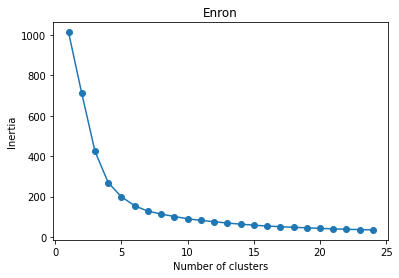

In [9]:
max_cluster = 25
inertias = classification.elbow_inertias_list(X[:,:2],max_cluster)

plt.figure()
plt.plot(range(1,max_cluster), inertias, marker='o')
plt.title('Enron')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('enron_elbow_two_dim.pdf')
plt.show() 

# SVM and K-Means merging hypothesis

Now we test our hypothesis, wether replacing the original labels with k-means generated labels can improve a svm classification

In [10]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(2,X,y)
report

It took 45.247589998994954 second(s) to search the best k-means clustering for merging hypothesis
It took 45.687650124993525 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.475788,0.0,0.467675,0.237894,0.230627
recall,0.964821,0.0,0.467675,0.482411,0.467675
f1-score,0.637300,0.0,0.467675,0.318650,0.308917
support,3269.000000,3475.0,0.467675,6744.000000,6744.000000


k-means with the original cluster count does not improve the classification

Got 3590 classificaton mistakes


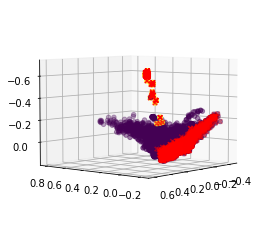

In [11]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

Now we estimate a good cluster count based on the graph

In [36]:
report, X_test, y_test, y_pred = classification.svm_merging_hypothesis(6,X,y)
report

It took 278.54228021799645 second(s) to search the best k-means clustering for merging hypothesis
It took 356.8115813579934 second(s) to complete the svm classification combined with k-means - merging hypothesis


,0,1,accuracy,macro avg,weighted avg
precision,0.694568,0.676185,0.684164,0.685377,0.685096
recall,0.621903,0.742734,0.684164,0.682318,0.684164
f1-score,0.656230,0.707899,0.684164,0.682064,0.682854
support,3269.000000,3475.000000,0.684164,6744.000000,6744.000000


Got 2130 classificaton mistakes


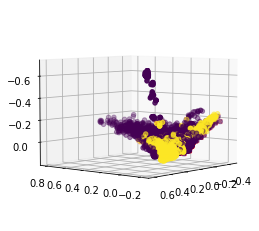

In [38]:
x_wrong = X_test[y_test != y_pred]
print("Got %d classificaton mistakes" % len(x_wrong))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter3D(X_test[:,0], X_test[:,1], X_test[:,2],c=y_pred, marker="o")
ax.scatter3D(x_wrong[:,0], x_wrong[:,1], x_wrong[:,2], color='red', marker="x")
ax.view_init(-175,140)
plt.show()

For increasing the number of clusters, the classification is getting worse.
The classification results are worse than the normal SVM
 
-> Merging is not a good approach

# Adding K-means clustering as new feature

we add now the k-means clustering result as a new column in our dataset and then classify the data with a svm. -> Test this approach with cluster count between 2 and 25

In [14]:
reference_report

,0,1,accuracy,macro avg,weighted avg
precision,0.992157,0.936754,0.961892,0.964455,0.963609
recall,0.928724,0.993094,0.961892,0.960909,0.961892
f1-score,0.959393,0.964101,0.961892,0.961747,0.961819
support,3269.000000,3475.000000,0.961892,6744.000000,6744.000000


In [15]:
report = classification.k_means_cluster_search(X,y,25)
report

,Number_of_clusters,Accuracy,F_one_Score,Time
0,2.0,0.961595,0.959077,46.699529
1,3.0,0.959520,0.956770,54.390200
2,4.0,0.932236,0.926892,69.120607
3,5.0,0.831702,0.829195,94.315560
4,6.0,0.529508,0.517854,86.084847
5,7.0,0.448102,0.418982,103.178124
6,8.0,0.536477,0.529642,83.837199
7,9.0,0.213523,0.172026,155.574670
8,10.0,0.745107,0.748427,101.228525
9,11.0,0.758304,0.720890,76.767513


Doesn't seems to be a good aproach too.

# Combine both approaches

Add the merging approach as a new feature vector to the dataset and then classify with svm.


In [39]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,6)
report

It took 338.1263395159913 second(s) to search the best k-means clustering for merging hypothesis


,Accuracy,F_one_Score,Time
0,0.94825,0.944506,413.739409


In [ ]:
report = classification.k_means_cluster_search_merging_hypothesis(X,y,21)
report

After a running time of ca. 1700min we interrupt the algorithm and decided this computation time is too high